In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [7]:
"""Mixture of Gaussians.

Perform inference with Metropolis-Hastings. It utterly fails. This is
because we are proposing a sample in a high-dimensional space. The
acceptance ratio is so small that it is unlikely we'll ever accept a
proposed sample. A Gibbs-like extension ("MH within Gibbs"), which
does a separate MH in each dimension, may succeed.

References
----------
http://edwardlib.org/tutorials/unsupervised
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import six
import tensorflow as tf

from edward.models import \
    Categorical, Dirichlet, Empirical, InverseGamma, Normal
from edward.models import Beta,Mixture,MultivariateNormalDiag,PointMass
from scipy.stats import norm


def build_toy_dataset(N):
  pi = np.array([0.4, 0.6])
  mus = [[1, 1], [-1, -1]]
  stds = [[0.1, 0.1], [0.1, 0.1]]
  x = np.zeros((N, 2))
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

  return x


N = 500  # number of data points
K = 2  # number of components
D = 2  # dimensionality of data
#ed.set_seed(42)

# DATA
x_data = build_toy_dataset(N)

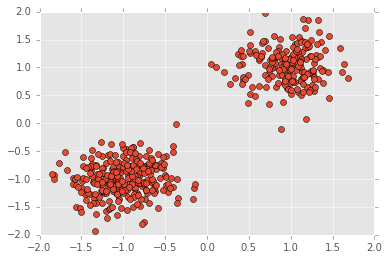

In [38]:
plt.plot(x_data[:,0],x_data[:,1],'o')

In [39]:

# MODEL
pi = Dirichlet(concentration=tf.constant([1.0] * K))
mu = Normal(loc=tf.zeros([K, D]), scale=tf.ones([K, D]))
sigma = InverseGamma(concentration=tf.ones([K, D]), rate=tf.ones([K, D]))
c = Categorical(logits=tf.tile(tf.reshape(ed.logit(pi), [1, K]), [N, 1]))
x = Normal(loc=tf.gather(mu, c), scale=tf.gather(sigma, c))

# INFERENCE
T = 5000
qpi = Empirical(params=tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(params=tf.Variable(tf.zeros([T, K, D])))
qsigma = Empirical(params=tf.Variable(tf.ones([T, K, D])))
qc = Empirical(params=tf.Variable(tf.zeros([T, N], dtype=tf.int32)))

gpi = Dirichlet(concentration=tf.constant([1.4, 1.6]))
gmu = Normal(loc=tf.constant([[1.0, 1.0], [-1.0, -1.0]]),
             scale=tf.constant([[0.5, 0.5], [0.5, 0.5]]))
gsigma = InverseGamma(concentration=tf.constant([[1.1, 1.1], [1.1, 1.1]]),
                      rate=tf.constant([[1.0, 1.0], [1.0, 1.0]]))
gc = Categorical(logits=tf.zeros([N, K]))

inference = ed.MetropolisHastings(
    latent_vars={pi: qpi, mu: qmu, sigma: qsigma, c: qc},
    proposal_vars={pi: gpi, mu: gmu, sigma: gsigma, c: gc},
    data={x: x_data})

inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)

  t = info_dict['t']
  if t == 1 or t % inference.n_print == 0:
    qpi_mean, qmu_mean = sess.run([qpi.mean(), qmu.mean()])
    print("")
    print("Inferred membership probabilities:")
    print(qpi_mean)
    print("Inferred cluster means:")
    print(qmu_mean)


   1/5000 [  0%]                                ETA: 10883s | Acceptance Rate: nan
Inferred membership probabilities:
[ 0.5  0.5]
Inferred cluster means:
[[ 0.  0.]
 [ 0.  0.]]
  50/5000 [  1%]                                ETA: 246s | Acceptance Rate: 0.000
Inferred membership probabilities:
[ 0.5  0.5]
Inferred cluster means:
[[ 0.  0.]
 [ 0.  0.]]
 100/5000 [  2%]                                ETA: 138s | Acceptance Rate: 0.000
Inferred membership probabilities:
[ 0.5  0.5]
Inferred cluster means:
[[ 0.  0.]
 [ 0.  0.]]
 150/5000 [  3%]                                ETA: 102s | Acceptance Rate: 0.000
Inferred membership probabilities:
[ 0.5  0.5]
Inferred cluster means:
[[ 0.  0.]
 [ 0.  0.]]
 200/5000 [  4%] █                              ETA: 84s | Acceptance Rate: 0.000 
Inferred membership probabilities:
[ 0.5  0.5]
Inferred cluster means:
[[ 0.  0.]
 [ 0.  0.]]
 250/5000 [  5%] █                              ETA: 75s | Acceptance Rate: 0.000
Inferred membership probabilities

In [5]:
qpi.params.eval()[1,:]

array([ 0.5,  0.5], dtype=float32)

In [144]:
# MODEL
pi = Dirichlet(concentration=tf.constant([1.0] * K))
mu = Normal(loc=tf.zeros([K, D]), scale=tf.ones([K, D]))
sigma = InverseGamma(concentration=tf.ones([K, D]), rate=tf.ones([K, D]))
c = Categorical(logits=tf.tile(tf.reshape(ed.logit(pi), [1, K]), [N, 1]))
x = Normal(loc=tf.gather(mu, c), scale=tf.gather(sigma, c))


In [145]:
# INFERENCE
T = 15000
qpi = Empirical(params=tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(params=tf.Variable(tf.zeros([T, K, D])))
qsigma = Empirical(params=tf.Variable(tf.ones([T, K, D])))
#qc = Empirical(params=tf.Variable(tf.zeros([T, N], dtype=tf.int32)))


In [146]:
'''
ds = tf.contrib.distributions

gpi = ed.models.TransformedDistribution(
  distribution = ds.Normal(loc=pi, scale=[0.01,0.01]),
  bijector=ds.bijectors.Affine(
    scale_identity_multiplier=1.0),
    #scale_identity_multiplier=1/tf.reduce_sum(pi)),
  name="ProbWithSmallNoise")
'''

gpi = Dirichlet(concentration=tf.constant([1.0] * K))

gmu = Normal(loc=mu,
             scale=tf.constant([0.01,0.01]))
gsigma = Normal(loc = sigma,
                scale = tf.constant([0.01,0.01]))
#gc = Categorical(logits=tf.zeros([N, K]))


In [147]:
inference = ed.MetropolisHastings(
    latent_vars={pi: qpi, mu: qmu, sigma: qsigma},
    proposal_vars={pi: gpi, mu: gmu, sigma: gsigma},
    data={x: x_data})


In [148]:
inference.run()

15000/15000 [100%] ██████████████████████████████ Elapsed: 11s | Acceptance Rate: 0.158


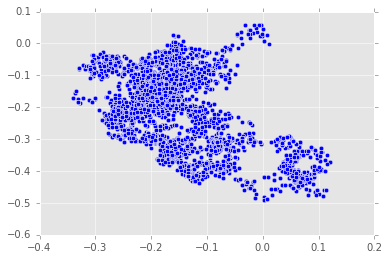

In [152]:
plt.scatter(qmu.params.eval()[:,0,0],qmu.params.eval()[:,0,1])

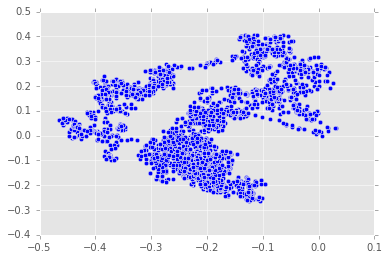

In [153]:
plt.scatter(qmu.params.eval()[:,1,0],qmu.params.eval()[:,1,1])

In [160]:
(tf.reduce_sum(qmu.params,0)).eval()/T

array([[-0.14663024, -0.21510866],
       [-0.2065192 ,  0.04707735]], dtype=float32)

In [159]:
qmu.shape[0]

Dimension(2)

## Kill evil Dirichlet!

In [8]:
# MODEL
#pi = Dirichlet(concentration=tf.constant([1.0] * K))

alpha = Beta(2.0,3.0)
_alpha = alpha.value()

#mu = Normal(loc=tf.zeros([K, D]), scale=tf.ones([K, D]))
mu = Normal(loc=[0.0,0.0], scale =[1.0,1.0], sample_shape=K)
#_mu = mu.value()
#sigma = InverseGamma(concentration=tf.ones([K, D]), rate=tf.ones([K, D]))
sigma = InverseGamma(concentration=[1.0,1.0], rate=[1.0,1.0], sample_shape=K)
#_sigma = sigma.value()
#c = Categorical(logits=tf.tile(tf.reshape(ed.logit(pi), [1, K]), [N, 1]))
#x = Normal(loc=tf.gather(mu, c), scale=tf.gather(sigma, c))


category = Categorical(probs = [_alpha, 1 - _alpha], sample_shape=N)
'''
components = [
    Normal(_mu[k], _sigma[k], sample_shape=N)
    for k in range(K)]
'''
x = Normal(loc=tf.gather(mu, category), scale=tf.gather(sigma, category))

#x = Mixture(cat=category, components=components, sample_shape=N)

In [48]:
# INFERENCE
T = 10000

ialpha = np.ones([T],dtype='float32') / K
imu = np.zeros([T, K, D],dtype='float32')
imu[0,:,:] = np.array([[1.0,1.0],[-1.0,-1.0]])
isigma = np.ones([T, K, D],dtype='float32')
isigma[0,:,:] = np.array([[0.1,0.1],[0.1,0.1]])

qalpha = Empirical(params=tf.Variable(ialpha))
qmu = Empirical(params=tf.Variable(imu))
qsigma = Empirical(params=tf.Variable(isigma))


In [49]:
galpha = Normal(loc = alpha, scale=0.00001)

gmu = Normal(loc=mu,
             scale=tf.constant([0.001,0.001]))
gsigma = Normal(loc = sigma,
                scale = tf.constant([0.001,0.001]))


In [50]:
inference = ed.MetropolisHastings(
    latent_vars   = {alpha: qalpha, mu: qmu, sigma: qsigma},
    proposal_vars = {alpha: galpha, mu: gmu, sigma: gsigma},
    data={x: x_data})


In [51]:
inference.run()

1000000/1000000 [100%] ██████████████████████████████ Elapsed: 562s | Acceptance Rate: 0.548


In [52]:
trace = qmu.params.eval()
trace.shape

(1000000, 2, 2)

In [53]:
half = trace.shape[0] // 2
last = trace.shape[0] // 10

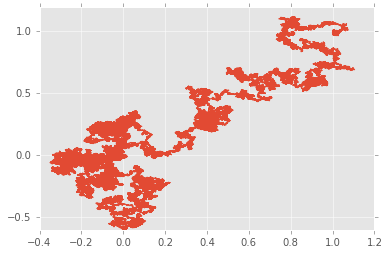

In [54]:
plt.plot(trace[:,0,0],trace[:,0,1])

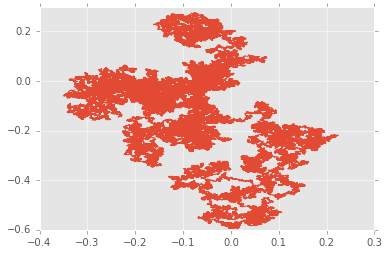

In [55]:
plt.plot(trace[half:,0,0],trace[half:,0,1])

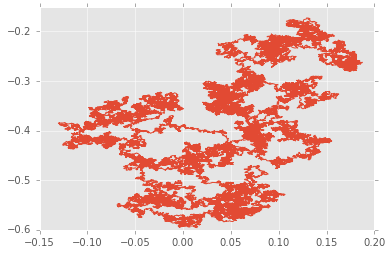

In [56]:
plt.plot(trace[-last:,0,0],trace[-last:,0,1])

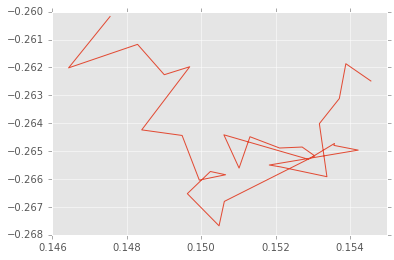

In [57]:
plt.plot(trace[-last:(-last+50),0,0],trace[-last:(-last+50),0,1])

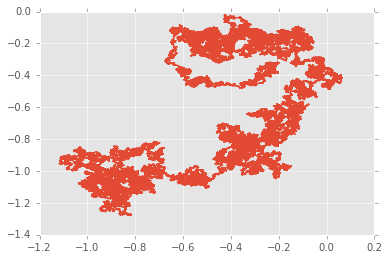

In [58]:
plt.plot(trace[:,1,0],trace[:,1,1])

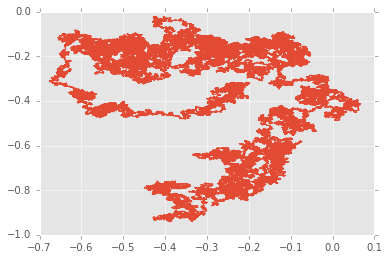

In [59]:
plt.plot(trace[half:,1,0],trace[half:,1,1])

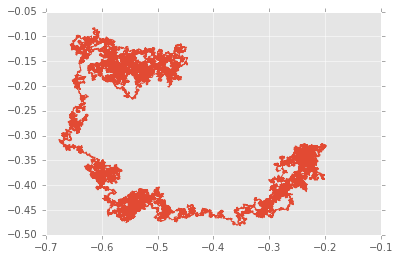

In [60]:
plt.plot(trace[-last:,1,0],trace[-last:,1,1])

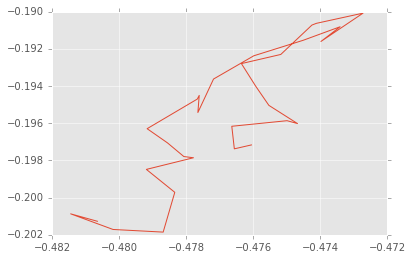

In [61]:
plt.plot(trace[-last:(-last+50),1,0],trace[-last:(-last+50),1,1])

In [62]:
np.mean(trace[-last:,:,:],0)

array([[ 0.04415213, -0.39007685],
       [-0.48037782, -0.29301509]], dtype=float32)

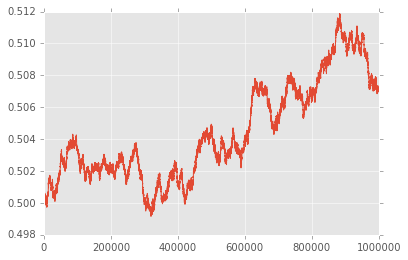

In [63]:
plt.plot(qalpha.params.eval())

In [64]:
np.mean(qalpha.params.eval()[-100:])

0.5071888

In [65]:
qsigma.params.eval().shape

(1000000, 2, 2)

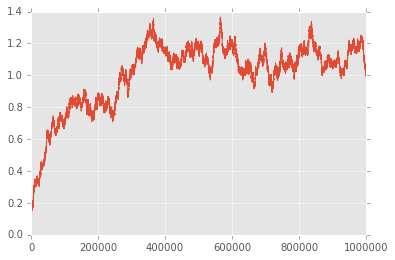

In [66]:
trace = qsigma.params.eval()
plt.plot(trace[:,0,0])

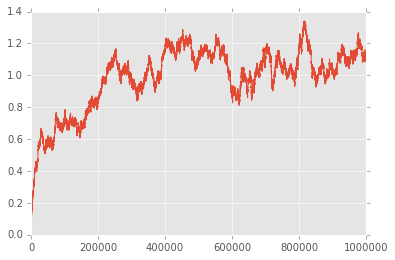

In [67]:
plt.plot(trace[:,0,1])

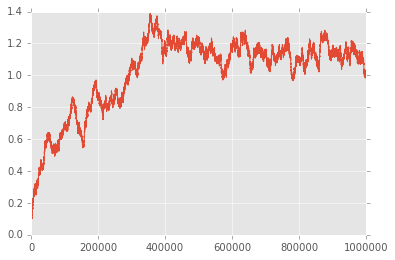

In [68]:
plt.plot(trace[:,1,0])

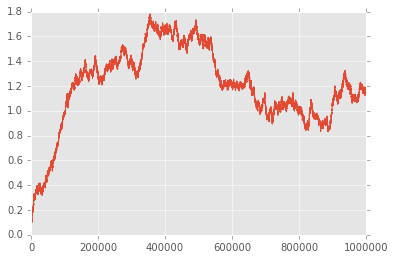

In [69]:
plt.plot(trace[:,1,1])

# MAP

In [31]:
# INFERENCE
from edward.models import PointMass
'''
qp_params = tf.sigmoid(tf.Variable(tf.random_normal([])))
qp = PointMass(params=qp_params)
'''

galpha = Normal(loc = alpha, scale=0.00001)

gmu = Normal(loc=mu,
             scale=tf.constant([0.001,0.001]))
gsigma = Normal(loc = sigma,
                scale = tf.constant([0.001,0.001]))

qalpha_p = tf.Variable(0.5)
qalpha = PointMass(params = qalpha_p)

#qmu_p = tf.Variable([[1.0,1.0],[-1.0,-1.0]])
qmu_p = tf.Variable([[0.25,0.25],[-0.25,-0.25]])
qmu = PointMass(params = qmu_p)

qsigma_p = tf.Variable([[1.0,1.0],[1.0,1.0]])
qsigma = PointMass(params = qsigma_p)

In [32]:
inference = ed.MAP({alpha: qalpha, sigma:qsigma, mu:qmu}, data={x: x_data})


In [33]:
inference.run(n_iter=10000)


10000/10000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 1447.253


In [34]:
qalpha.eval()

0.33333331

In [35]:
qsigma.eval()

array([[ 1.00576138,  1.03175426],
       [ 1.00622082,  1.03253341]], dtype=float32)

In [36]:
qmu.eval()

array([[-0.22736372, -0.19095199],
       [-0.2287333 , -0.19339478]], dtype=float32)

Fine, let's try Gibbs again..

In [40]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture,Empirical

K = 2  # number of components

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)}, MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat


T = 500  # number of MCMC samples
qpi = Empirical(tf.Variable(tf.ones([T, K]) / K))
qmu = Empirical(tf.Variable(tf.zeros([T, K, D])))
qsigmasq = Empirical(tf.Variable(tf.ones([T, K, D])))
qz = Empirical(tf.Variable(tf.zeros([T, N], dtype=tf.int32)))


inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz}, data={x: x_data})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  if t % inference.n_print == 0:
    print("\nInferred cluster means:")
    print(sess.run(running_cluster_means, {t_ph: t - 1}))


  5/500 [  1%]                                ETA: 221s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.24232306 -0.23219767]
 [-0.10028976  0.64093173]]
 10/500 [  2%]                                ETA: 119s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.55573583 -0.55036354]
 [ 0.50391346  0.88564706]]
 15/500 [  3%]                                ETA: 80s | Acceptance Rate: 1.000 
Inferred cluster means:
[[-0.71489292 -0.70423967]
 [ 0.67162263  0.93808299]]
 20/500 [  4%] █                              ETA: 60s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.79238367 -0.77651554]
 [ 0.75214463  0.95966411]]
 25/500 [  5%] █                              ETA: 48s | Acceptance Rate: 1.000
Inferred cluster means:
[[-0.83745146 -0.81816238]
 [ 0.7952438   0.96953869]]
 30/500 [  6%] █                              ETA: 40s | Acceptance Rate: 1.034
Inferred cluster means:
[[-0.86614811 -0.84577382]
 [ 0.82296616  0.98022091]]
 35/500 [  7%] ██                          

In [45]:


inference = ed.MAP([pi,mu,sigmasq,z],data={x:x_data})

TypeError: Key-value pair in latent_vars does not have same shape: (2,), ()